In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt

In [19]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow', 'MidUpperArm'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

In [20]:
# defining my path to pt one
IO_03_09_2023_RSTN = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_09_2023_RSTN_subject1\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(IO_03_09_2023_RSTN.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(IO_03_09_2023_RSTN.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")

     bodyparts            PalmBase         PalmBase.1           PalmBase.2  \
0       coords                   x                  y           likelihood   
1            0   427.6842041015625  525.0423583984375  0.14588609337806702   
2            1   427.5551452636719  525.5269775390625   0.1911419928073883   
3            2   428.8374938964844  525.0931396484375  0.17686539888381958   
4            3   427.6429138183594  525.9227905273438   0.1331915706396103   
...        ...                 ...                ...                  ...   
4254      4253   409.2789306640625  529.5111694335938  0.20932647585868835   
4255      4254        410.21484375  528.4324951171875   0.1871751844882965   
4256      4255  409.49407958984375   529.206298828125  0.22666633129119873   
4257      4256   409.3077697753906  529.0945434570312  0.23516501486301422   
4258      4257   409.7013854980469  529.1215209960938   0.1964298039674759   

                    MCP1             MCP1.1               MCP1.

In [21]:
b1f = dataframes['b1f']

In [22]:
b1f

,PalmBase,PalmBase.1,PalmBase.2,MCP1,MCP1.1,MCP1.2,MCP2,MCP2.1,MCP2.2,MCP3,...,fTip5.2,MidForeArm,MidForeArm.1,MidForeArm.2,Elbow,Elbow.1,Elbow.2,MidUpperArm,MidUpperArm.1,MidUpperArm.2
1,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,...,NaN,403.50226,498.96652,0.96144,0.00000,0.00000,NaN,0.0,0.0,NaN
2,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,...,NaN,403.92142,498.57404,0.97414,0.00000,0.00000,NaN,0.0,0.0,NaN
3,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,...,NaN,403.67477,499.32172,0.97494,0.00000,0.00000,NaN,0.0,0.0,NaN
4,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,...,NaN,403.82156,498.84067,0.97444,0.00000,0.00000,NaN,0.0,0.0,NaN
5,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,0.00000,...,NaN,403.57819,499.19968,0.98218,0.00000,0.00000,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4254,421.39304,517.78931,0.20933,401.88693,512.87585,0.94712,419.35519,505.83731,0.99490,433.84900,...,0.04167,399.36777,498.08112,0.95745,412.41174,509.74567,0.05781,0.0,0.0,NaN
4255,421.39304,517.78931,0.18718,401.88693,512.87585,0.93889,419.33099,505.77332,0.99508,434.20978,...,0.03273,399.50476,497.88647,0.95297,412.41174,509.74567,0.06670,0.0,0.0,NaN
4256,421.39304,517.78931,0.22667,401.88693,512.87585,0.94178,419.25885,505.88922,0.99413,433.54303,...,0.03111,399.65521,498.39529,0.95158,412.41174,509.74567,0.06914,0.0,0.0,NaN
4257,421.39304,517.78931,0.23517,401.88693,512.87585,0.94368,418.84924,506.24756,0.99355,433.41946,...,0.02979,399.34567,498.01099,0.96211,412.41174,509.74567,0.06746,0.0,0.0,NaN


b1f MCP1 (X) — Change points: [420, 610, 1105, 2230, 3710, 4420, 4936]
b1f MCP1.1 (Y) — Change points: [420, 595, 1470, 2280, 3465, 4936]
b1s MCP1 (X) — Change points: [430, 3013]
b1s MCP1.1 (Y) — Change points: [430, 1300, 1980, 2720, 3013]


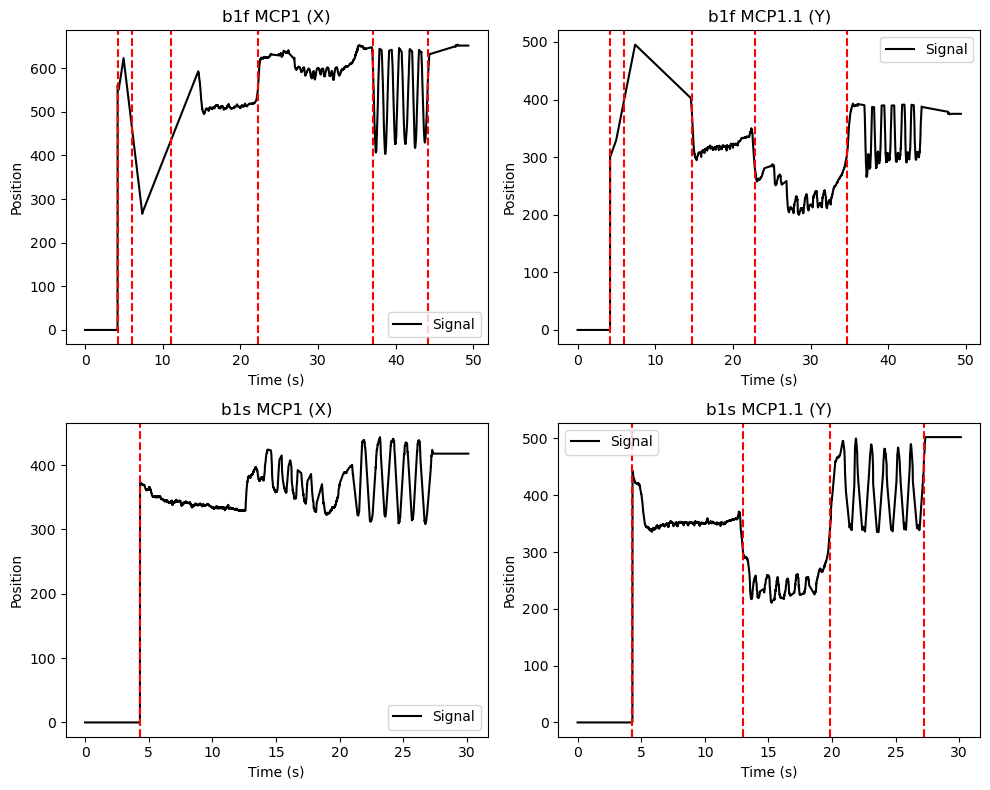

In [29]:
# Pulling data from the dataframe
c1f = dataframes['c1f']
c1s = dataframes['c1s']
xf = c1f['MCP1']
yf = c1f['MCP1.1']
xs = c1s['MCP1']
ys = c1s['MCP1.1']

views = [xf, yf, xs, ys]
titles = ['b1f MCP1 (X)', 'b1f MCP1.1 (Y)', 'b1s MCP1 (X)', 'b1s MCP1.1 (Y)']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, (view, title) in enumerate(zip(views, titles)):
    length = len(view)
    step = 0.01  # 100 FPS
    t = np.linspace(0, (length - 1) * step, length)

    
    data_np = view.to_numpy()
    
    # Run PELT algorithm
    algo = rpt.Pelt(model="l2").fit(data_np)
    result = algo.predict(pen=1e6)
    
    print(f"{title} — Change points:", result)
    
    # Plot data
    axs[i].plot(t, data_np, color='black', label='Signal')
    
    # Plot detected change points
    for cp in result:
        if cp < len(t):
            axs[i].axvline(t[cp], color='red', linestyle='--')
    
    axs[i].set_title(title)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Position')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import ruptures as rpt

# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['MCP1.1']
    points_np = points.to_numpy()

    algo = rpt.Pelt(model='l2').fit(points_np)
    change_points = algo.predict(pen=1e6)

    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = change_points

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)


In [25]:
df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [26]:
df_indices


,dataset,front,side,front_length
0,b1,"[1745, 2515, 3215, 4010, 4258]","[1970, 2805, 3515, 4556]",5
1,b2,"[400, 1345, 2155, 2965, 3271]","[390, 1345, 2160, 3223]",5
2,b3,"[335, 1330, 2070, 2845, 3053]","[330, 1205, 1970, 2947]",5
3,c1,"[420, 595, 1470, 2280, 3465, 4936]","[430, 1300, 1980, 2720, 3013]",6
4,c2,None,"[495, 1375, 2170, 3219]",0
5,c3,"[570, 1415, 2325, 3100, 3368]","[570, 1365, 2265, 3268]",5
6,t1,"[145, 619]",[622],2
7,t2,[498],[522],1
8,t3,"[280, 1320, 2175, 2400, 3110, 3575]","[295, 1320, 2140, 3531]",6


In [30]:
success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [4, 5]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)

['b1f', 'b2f', 'b3f', 'c1s', 'c2s', 'c3f', 't1s', 't2s', 't3s']


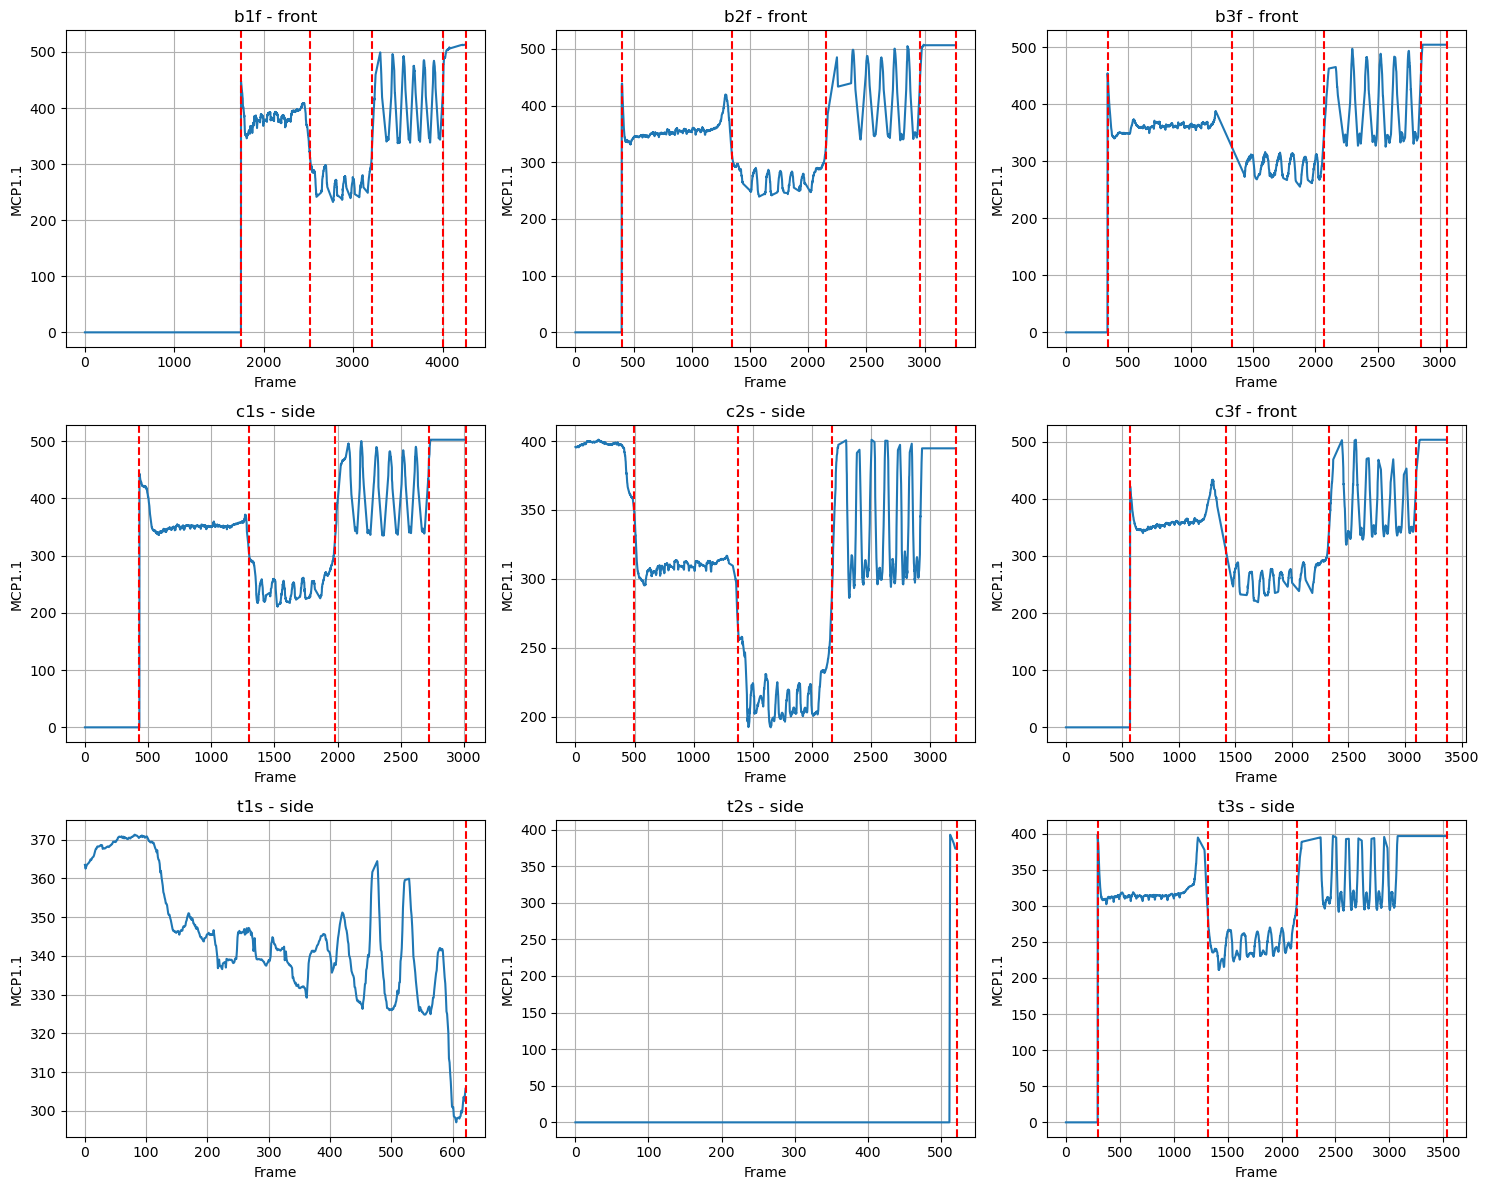

In [31]:
# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df['MCP1.1'].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label='MCP1.1')
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("MCP1.1")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()